In [ ]:
import numpy as np
import pandas as pd
import glob
import sklearn
import lazypredict

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import matplotlib.pyplot as plt

Mounted at /content/gdrive


In [ ]:
#search in the directory and look for everyfile which ends .ict
files=glob.glob('gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/*.ict')
#sort the list of files into numerical order
files.sort()

#set up an variable which is True at the start
first=True

#Loop over each of the files and let file store the name of the file that we are interested from that list

for file in files:
  #The datafiles have a strange format. They are like a csv file but have a header at the start. The number of lines in the header is
  #the first line of the file. So we read in the file as a text file, look at the first line and workout how many lines we have to skip to get to
  #to the CSV part of the file.
  print(file)
  f = open(file,"r")
  line=f.readline()
  skip=int(line.split(",")[0])
  f.close()

  #Read in the file using Pandas but skip the first header lines.
  data=pd.read_csv(file,skiprows=skip-1)

  #If this is the 1st time through the loop (the first file) then copy the data in the file to DataFrame all_data and then reset the first flag to False
  #If this isn't the 1st time through the loop then copy to the data in the file to the end of the DataFrame all data.
  if(first):
    all_data=data
    first=False
  else:
    all_data=pd.concat([all_data,data])

gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160729_R35.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160801_R37.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160803_R31.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160806_R31.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160808_R31.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160812_R31.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160815_R29.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160817_R28.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160820_R28.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160822_R29.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20160823_R28.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/MER10_DC8_20170126_R27.ict
gdrive/MyDrive/Bachelors Project/ATom_MER10_Dataset/

In [ ]:
import pandas as pd

def find_N_variables_with_most_data_loss(data, N):
    # Replace values below 0 with NaN to treat them as missing data
    data = data.applymap(lambda x: x if x >= 0 else None)

    # Calculate the percentage of missing values for each column
    missing_percentage = (data.isnull().mean() * 100).round(2)

    # Sort columns by missing percentage in descending order and select the top N
    most_data_loss_columns = missing_percentage.sort_values(ascending=False).head(N)

    return most_data_loss_columns


In [ ]:
from re import X
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

all_data.reset_index(inplace=True, drop=True)#reset the index of the dataframe
columns = ['CH2O','PAN_GTCIMS', 'P', 'RHw_DLH', 'H2O_DLH', 'N2O_QCLS', 'CO_QCLS', 'CO2_QCLS','T', 'OH_ATHOS', 'CH4_QCLS', 'O3_CL', 'NO_CL', 'NO2_CL', 'Solar_Zenith_Angle']
columns_to_remove = ['UTC_Start', 'UTC_Stop', 'OH_GMI', 'Longitude', 'Latitude']
inputsa = all_data[columns]
inputsb = all_data[columns_to_remove]
inputsb = inputsb[inputsb >= -180].dropna()
inputsa = inputsa[inputsa >= 0].dropna() #drop the rows with NaN values
inputs = inputsa.join(inputsb)

inputsy_dataframe = inputs["OH_ATHOS"].to_frame()  # Convert OH_ATHOS to a DataFrame
inputs = inputs.drop(columns="OH_ATHOS")

if inputsy_dataframe.shape[0] == inputs.shape[0] and inputs.shape[0] != 0: #check the dimensionality
    X_train, X_test, y_train, y_test = train_test_split(inputs, inputsy_dataframe, test_size=0.2, random_state=1)  # 80% training data
    columns.remove('OH_ATHOS')

else:
    print("Dimensionality wrong or No row with good data")


X_train_time = X_train[columns_to_remove]
Latitude = X_train_time['Latitude']
X_train = X_train.drop(columns=columns_to_remove, axis=1)
X_train = X_train.join(Latitude) #add latitude back as training feature
X_test_time = X_test[columns_to_remove]
Latitude = X_test_time['Latitude']#add latitude from the test set
X_test = X_test.drop(columns=columns_to_remove, axis=1)
X_test = X_test.join(Latitude)

y_train = y_train.values.ravel() # Use .ravel() to reshape y_train to a 1D array

def remove(columns_to_filter, dataframe):
    for column_name in columns_to_filter:
        if column_name in dataframe.columns:
            # Filter the rows where the specified column is non-negative and not NaN
            dataframe = dataframe[(dataframe[column_name] >= 0) & ~dataframe[column_name].isna()]
        else:
            print(f"Column '{column_name}' not found in the DataFrame.")

    return dataframe

def filter(column_name, dataframe): #function to remove a column
    # Check if the column exists in the DataFrame
    if column_name in dataframe.columns:
        # Drop the specified column
        dataframe = dataframe.drop(columns=[column_name])
        return dataframe
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return dataframe  # Return the original DataFrame
def keep(column_name, dataframe): #function to keep a column from a dataframe
    # Check if the column exists in the DataFrame
    if column_name in dataframe.columns:
        # Keep the specified column
        dataframe = dataframe[column_name]
        return dataframe
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return dataframe  # Return the original DataFrame


inputs_filter = filter("UTC_Start", inputsa) #remove columns use.drop
inputs_filter = filter("UTC_Stop", inputs_filter) #remove columns


all_OH = keep("OH_ATHOS", inputsa) #dataframe containing all OH measurements




Column 'UTC_Start' not found in the DataFrame.
Column 'UTC_Stop' not found in the DataFrame.


In [ ]:
# Create and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators = 170, max_depth = 9, random_state = 5)
model.fit(X_train, y_train)
# Make predictions on the test set (X_test)
predictions = model.predict(X_test)
# Make predictions on the training set
predictions_train = model.predict(X_train)
# Create a DataFrame for the predictions
output1 = pd.DataFrame({'OH Concentration': predictions})
# Reset the index for the X_test and output1 DataFrames
X_test.reset_index(drop=True, inplace=True)
output1.reset_index(drop=True, inplace=True)
output = pd.concat([output1, X_test], axis = 1) #concatenate predictions with test set
# Save the predictions to a CSV file alongside the training set
output.to_csv('OH_values.csv', index=False)
print("OH_values.csv was successfully saved")

# Calculate which feature is causing the most data loss
N = 16
most_loss_columns = find_N_variables_with_most_data_loss(inputsa, N)

print(f"The {N} variables with the highest data loss:")
for column, percentage in most_loss_columns.items():
    print(f"'{column}' has {percentage}% missing values.")

OH_values.csv was successfully saved
The 16 variables with the highest data loss:
'CH2O' has 0.0% missing values.
'PAN_GTCIMS' has 0.0% missing values.
'P' has 0.0% missing values.
'RHw_DLH' has 0.0% missing values.
'H2O_DLH' has 0.0% missing values.
'N2O_QCLS' has 0.0% missing values.
'CO_QCLS' has 0.0% missing values.
'CO2_QCLS' has 0.0% missing values.
'T' has 0.0% missing values.
'OH_ATHOS' has 0.0% missing values.
'CH4_QCLS' has 0.0% missing values.
'O3_CL' has 0.0% missing values.
'NO_CL' has 0.0% missing values.
'NO2_CL' has 0.0% missing values.
'Solar_Zenith_Angle' has 0.0% missing values.


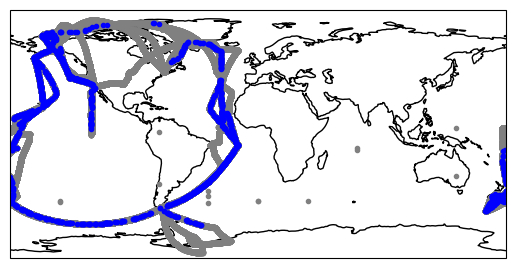

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()

Latitude1 = inputsb['Latitude']
Longitude1 = inputsb['Longitude']
plt.plot([Longitude1], [Latitude1],
         color='gray', linewidth=0.5, marker='.',
         transform=ccrs.PlateCarree(),
         )
Latitude = X_test['Latitude']
Longitude = X_test_time['Longitude']
ax1.plot([Longitude], [Latitude],
         color='blue', linewidth=0.5, marker='.',
         transform=ccrs.PlateCarree(),
         )
# Save the plot by calling plt.savefig() BEFORE plt.show()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)


# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2) Score: {r2}')


Mean Absolute Error (MAE): 0.036738656049881045
Mean Squared Error (MSE): 0.004456025909258113
Root Mean Squared Error (RMSE): 0.06675347114014456
R-squared (R2) Score: 0.806862645750197


The column 'CO_QCLS' was not averaged. Test: True, DataFrame columns: True


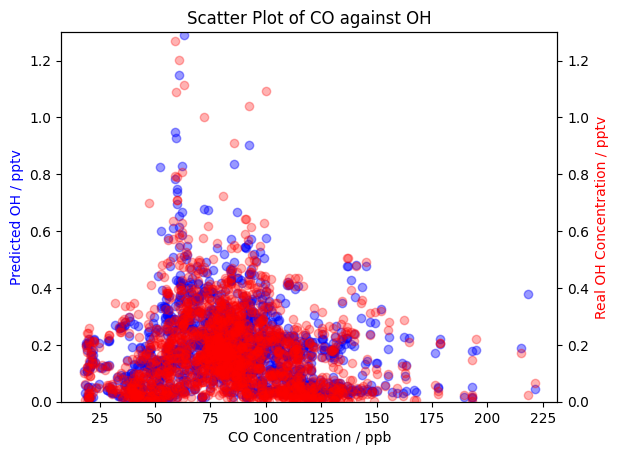

The column 'NO_CL' was not averaged. Test: True, DataFrame columns: True


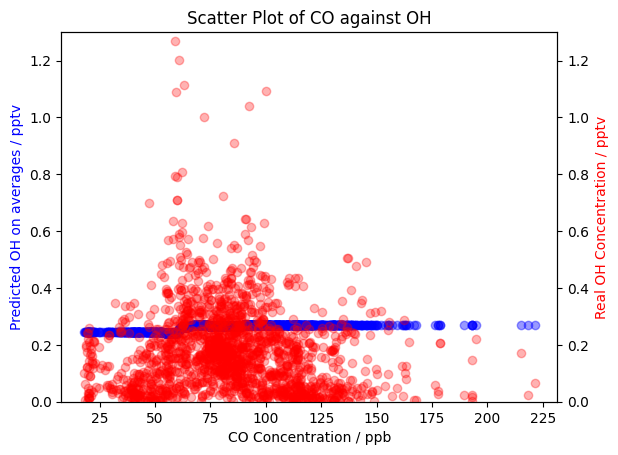

The column 'NO_CL' was not averaged. Test: True, DataFrame columns: True


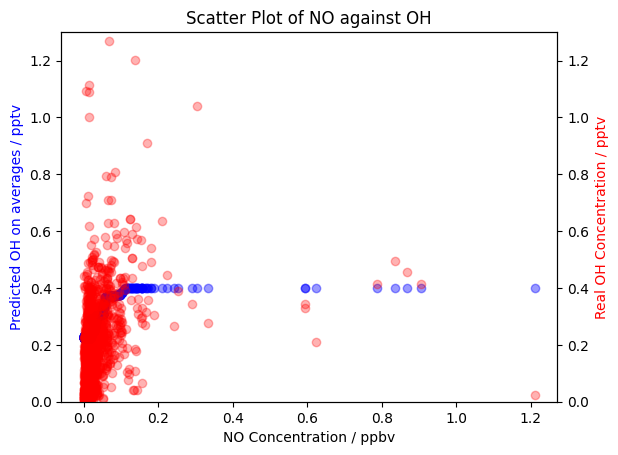

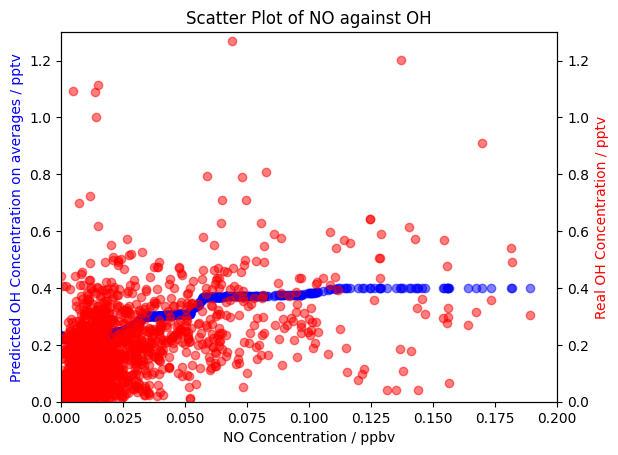

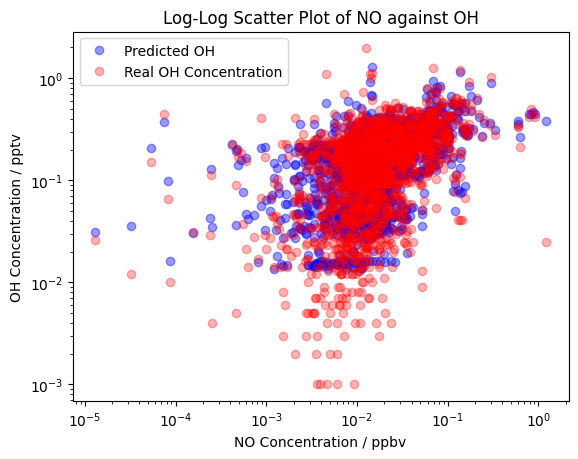

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mean(columns, dataframe, test):
    for column_name in columns:
        if column_name not in test and column_name in dataframe.columns:
            dataframe[column_name] = dataframe[column_name].mean()
        else:
            print(f"The column '{column_name}' was not averaged. Test: {column_name in test}, DataFrame columns: {column_name in dataframe.columns}")

    return dataframe

def log(input, column, new_column_name):
  log_values = []
  for i in input[column]:
    values = np.log10(i)
    log_values.append(values)

  input[new_column_name] = log_values

  return log_values

CO_curve = mean(columns_to_filter, X_test.copy(), 'CO_QCLS')
CO_based_predictions = model.predict(CO_curve)

fig, ax1 = plt.subplots()

ax1.scatter(X_test['CO_QCLS'], output['OH Concentration'], color='blue', label='Predicted OH averaged', alpha=0.4)
ax1.set_xlabel('CO Concentration / ppb')
ax1.set_ylabel('Predicted OH / pptv', color='blue')
ax1.set_ylim(0, max(np.array(CO_based_predictions).flatten().max(), output['OH Concentration'].max()) + 0.01)  # Adjust the range as needed

# Create a second y-axis for the real concentration of OH
ax2 = ax1.twinx()
ax2.scatter(CO_curve['CO_QCLS'], y_test, color='red', label='Predicted OH Concentration', alpha=0.3)
ax2.set_ylabel('Real OH Concentration / pptv', color='red')
ax2.set_ylim(0, max(OH_CONC.max(), output['OH Concentration'].max()) + 0.01)  # Adjust the range as needed

# Set the title
plt.title('Scatter Plot of CO against OH')

# Show the plot
plt.show()

param = ['NO_CL']
NO_curve = mean(columns_to_filter, X_test.copy(), param)

NO_based_predictions = model.predict(NO_curve)

OH_CONC = np.array(NO_based_predictions).flatten()



# Scatter plot for NO concentration against OH
fig, ax1 = plt.subplots()

ax1.scatter(CO_curve['CO_QCLS'], np.array(CO_based_predictions).flatten(), color='blue', label='Predicted OH averaged', alpha=0.4)
ax1.set_xlabel('CO Concentration / ppb')
ax1.set_ylabel('Predicted OH on averages / pptv', color='blue')
ax1.set_ylim(0, max(np.array(CO_based_predictions).flatten().max(), output['OH Concentration'].max()) + 0.01)  # Adjust the range as needed

# Create a second y-axis for the real concentration of OH
ax2 = ax1.twinx()
ax2.scatter(CO_curve['CO_QCLS'], y_test, color='red', label='Predicted OH Concentration', alpha=0.3)
ax2.set_ylabel('Real OH Concentration / pptv', color='red')
ax2.set_ylim(0, max(OH_CONC.max(), output['OH Concentration'].max()) + 0.01)  # Adjust the range as needed

# Set the title
plt.title('Scatter Plot of CO against OH')

# Show the plot
plt.show()

param = ['NO_CL']
NO_curve = mean(columns_to_filter, X_test.copy(), param)

NO_based_predictions = model.predict(NO_curve)

OH_CONC = np.array(NO_based_predictions).flatten()

# Scatter plot for NO concentration against OH
fig, ax1 = plt.subplots()

ax1.scatter(NO_curve['NO_CL'], OH_CONC, color='blue', label='Predicted OH averaged', alpha=0.4)
ax1.set_xlabel('NO Concentration / ppbv')
ax1.set_ylabel('Predicted OH on averages / pptv', color='blue')
ax1.set_ylim(0, max(OH_CONC.max(), output['OH Concentration'].max()) + 0.01)  # Adjust the range as needed

# Create a second y-axis for the real concentration of OH
ax2 = ax1.twinx()
ax2.scatter(NO_curve['NO_CL'], y_test, color='red', label='Predicted OH Concentration', alpha=0.3)
ax2.set_ylabel('Real OH Concentration / pptv', color='red')
ax2.set_ylim(0, max(OH_CONC.max(), output['OH Concentration'].max()) + 0.01)  # Adjust the range as needed

# Set the title
plt.title('Scatter Plot of NO against OH')

# Show the plot
plt.show()

# Scatter plot for NO concentration against OH
fig, ax1 = plt.subplots()

ax1.scatter(NO_curve['NO_CL'], OH_CONC, color='blue', label='Predicted OH averaged', alpha=0.5)
ax1.set_xlabel('NO Concentration / ppbv')
ax1.set_ylabel('Predicted OH Concentration on averages / pptv', color='blue')
ax1.set_ylim(0, max(OH_CONC.max(), output['OH Concentration'].max()) + 0.01)  # Adjust the range as needed
ax1.set_xlim(0, 0.2)  # Set x-axis limits

# Create a second y-axis for the real concentration of OH
ax2 = ax1.twinx()
ax2.scatter(NO_curve['NO_CL'], y_test, color='red', label='Predicted OH Concentration', alpha=0.5)
ax2.set_ylabel('Real OH Concentration / pptv', color='red')
ax2.set_ylim(0, max(OH_CONC.max(), output['OH Concentration'].max()) + 0.01)  # Adjust the range as needed

# Set the title
plt.title('Scatter Plot of NO against OH')

# Show the plot
plt.show()

plt.loglog(NO_curve['NO_CL'], output['OH Concentration'], 'o', color='blue', label='Predicted OH', alpha=0.4)
plt.loglog(NO_curve['NO_CL'], y_test, 'o', color='red', label='Real OH Concentration', alpha=0.3)
plt.xlabel('NO Concentration / ppbv')
plt.ylabel('OH Concentration / pptv')
plt.title('Log-Log Scatter Plot of NO against OH')
plt.legend()
plt.show()

The column 'O3_CL' was not averaged. Test: True, DataFrame columns: True


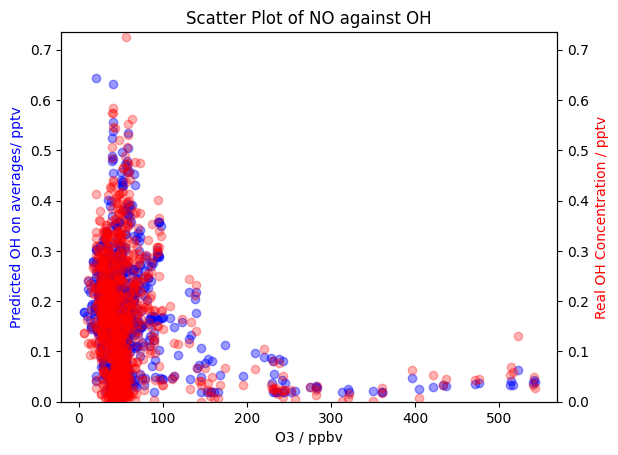

In [ ]:
O3_curve = mean(columns_to_filter, X_test.copy(), 'O3_CL')
O3_based_predictions = model.predict(O3_curve)
OH_CONC = np.array(O3_based_predictions).flatten()

# Scatter plot for NO concentration against OH
fig, ax1 = plt.subplots()
x=output['O3_CL']
y1=output['OH Concentration']
y2=y_test
max_y_value = max(y1.max(), y2.max().values[0])
ax1.scatter(x, y1, color='blue', label='Predicted OH', alpha=0.4)
ax1.set_xlabel('O3 / ppbv')
ax1.set_ylabel('Predicted OH on averages/ pptv', color='blue')
ax1.set_ylim(0, max_y_value + 0.01)  # Adjust the range as needed

# Create a second y-axis for the real concentration of OH
ax2 = ax1.twinx()
ax2.scatter(x, y2, color='red', label='Real OH Concentration', alpha=0.3)
ax2.set_ylabel('Real OH Concentration / pptv', color='red')
ax2.set_ylim(0, max_y_value + 0.01)

# Set the title
plt.title('Scatter Plot of NO against OH')

# Show the plot
plt.show()

Gradient of the line of best fit for Observed vs GMI 0.6643862593526543
Gradient of the line of best fit for Observed vs Modelled 0.7784658030508


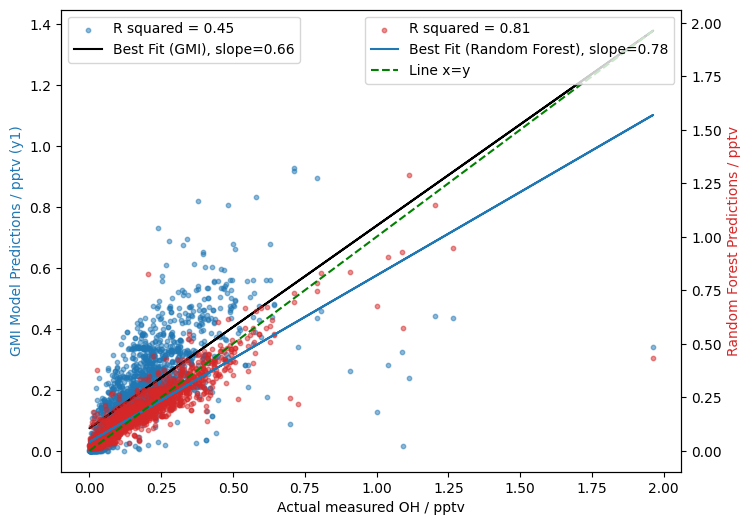

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import linregress

# Your data and calculations here...

#'X_train_time' is the DataFrame containing 'UTC_Start'
x = y_test  # [test data]
x_flat = np.array(x).flatten()
y5 = X_test_time['OH_GMI']
y5 = y5.mul(1000)
y6 = output['OH Concentration']  # model predictions for test data
y6 = y6.to_numpy()  # convert y6 into an array

r2 = r2_score(y_test, predictions)
r2 = round(r2, 2)
r2_GMI = r2_score(y_test, y5)
r2_GMI = round(r2_GMI, 2)

# Create a line plot for the second y-variable using a secondary y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.set_xlabel('Actual measured OH / pptv')
ax1.set_ylabel('GMI Model Predictions / pptv (y1)', color='tab:blue')
ax1.scatter(x, y5, s=10, color='tab:blue', alpha=0.5, label=f'R squared = {r2_GMI}')

# Fit a line of best fit for y5 vs. x using linregress
slope_y5, intercept_y5, _, _, _ = linregress(x_flat, y5)
plt.plot(x, slope_y5*x + intercept_y5, color='black', label=f'Best Fit (GMI), slope={round(slope_y5, 2)}')

# Print the gradient for y5 vs. x
print("Gradient of the line of best fit for Observed vs GMI", slope_y5)

ax2 = ax1.twinx()
ax2.set_ylabel('Random Forest Predictions / pptv', color='tab:red')
ax2.scatter(x, y6, s=10, color='tab:red', alpha=0.5, label=f'R squared = {r2}')

# Fit a line of best fit for y6 vs. x using linregress
slope_y6, intercept_y6, _, _, _ = linregress(x_flat, y6)
plt.plot(x, slope_y6*x + intercept_y6, label=f'Best Fit (Random Forest), slope={round(slope_y6, 2)}')

# Print the gradient for y6 vs. x
print("Gradient of the line of best fit for Observed vs Modelled", slope_y6)

# Plot the line x=y
plt.plot([min(x_flat), max(x_flat)], [min(x_flat), max(x_flat)], linestyle='--', color='green', label='Line x=y')

# ... (rest of your code)

# Display the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


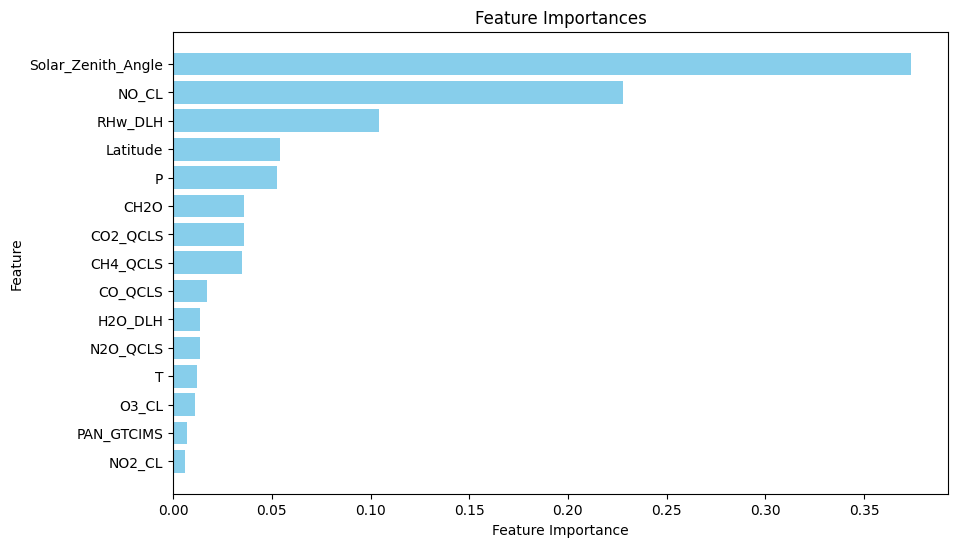

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to associate feature names with their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to show most important features at the top
plt.show()


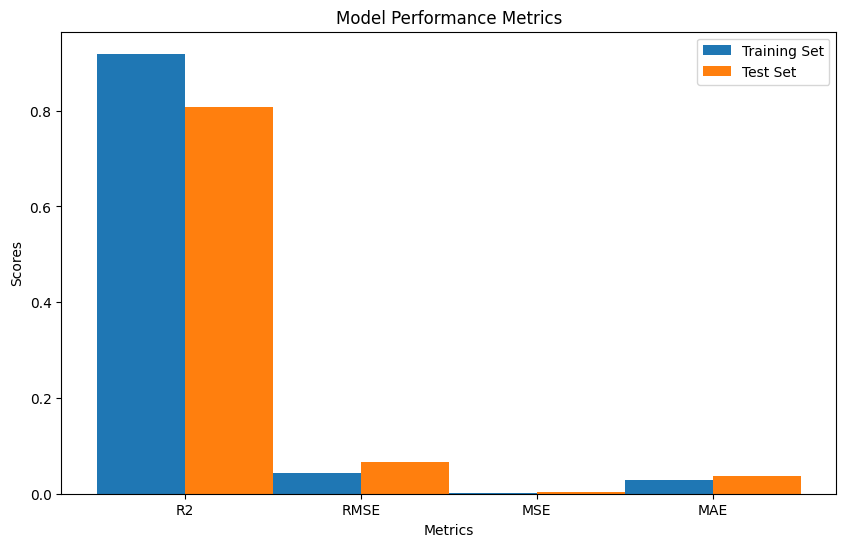

In [ ]:
import numpy as np

#compare predictions of training to training set
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train, squared=False)
r2_train = r2_score(y_train, predictions_train)


# Define the metrics and datasets
metrics = ['R2', 'RMSE', 'MSE', 'MAE']
training_scores = [r2_train, rmse_train, mse_train, mae_train]
test_scores = [r2, rmse, mse, mae]

# Create a bar chart to compare metrics
x = np.arange(len(metrics))
width = 0.5
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, training_scores, width, label='Training Set')
plt.bar(x + width/2, test_scores, width, label='Test Set')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.xticks(x, metrics)
plt.legend()
plt.show()


In [ ]:
import pandas as pd

#inputsa contains all the data with the desired features
correlation_matrix = X_train.corr()

# Create DataFrames to store the most and least correlated feature pairs
most_correlated_features = pd.DataFrame(columns=['Feature1', 'Feature2', 'Correlation'])
least_correlated_features = pd.DataFrame(columns=['Feature1', 'Feature2', 'Correlation'])

# Loop through the correlation matrix to find the most and least correlations
for feature1 in X_train.columns:
    for feature2 in X_train.columns:
        if feature1 != feature2:
            correlation = correlation_matrix.loc[feature1, feature2]
            most_correlated_features = pd.concat([most_correlated_features, pd.DataFrame({'Feature1': [feature1], 'Feature2': [feature2], 'Correlation': [correlation]})], ignore_index=True)
            least_correlated_features = pd.concat([least_correlated_features, pd.DataFrame({'Feature1': [feature1], 'Feature2': [feature2], 'Correlation': [correlation]})], ignore_index=True)

# Sort the DataFrames by correlation values
most_correlated_features = most_correlated_features.reindex(most_correlated_features['Correlation'].abs().sort_values(ascending=False).index)
least_correlated_features = least_correlated_features.reindex(least_correlated_features['Correlation'].abs().sort_values().index)

# Print the top N most correlated feature pairs
N = 30  # You can change N to see more or fewer pairs
M = 10
print("Top", N, "most correlated feature pairs:")
print(most_correlated_features.head(N))

# Print the top N least correlated feature pairs
print("Top", M, "least correlated feature pairs:")
print(least_correlated_features.head(M))


Top 30 most correlated feature pairs:
       Feature1    Feature2  Correlation
35            P           T         0.92
114           T           P         0.92
145       O3_CL    N2O_QCLS        -0.85
79     N2O_QCLS       O3_CL        -0.85
132    CH4_QCLS     CO_QCLS         0.80
92      CO_QCLS    CH4_QCLS         0.80
205    Latitude    CH4_QCLS         0.78
139    CH4_QCLS    Latitude         0.78
56      H2O_DLH        CH2O         0.75
3          CH2O     H2O_DLH         0.75
58      H2O_DLH           P         0.74
31            P     H2O_DLH         0.74
7          CH2O           T         0.74
112           T        CH2O         0.74
116           T     H2O_DLH         0.71
63      H2O_DLH           T         0.71
1          CH2O           P         0.70
28            P        CH2O         0.70
131    CH4_QCLS    N2O_QCLS         0.62
78     N2O_QCLS    CH4_QCLS         0.62
85      CO_QCLS  PAN_GTCIMS         0.62
19   PAN_GTCIMS     CO_QCLS         0.62
179      NO2_CL    